1. Nettoyage
2. Analyse des variables
3. Encodage (OneHot, LabelEncoder...)
4. Normalisation (et centrage)
5. Split données
6. Fit sur X_train, y_train 
7. Score sur X_test, y_test

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [129]:
df = pd.read_csv('data/data.csv')
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


# Ajout de features

In [85]:
#df['bmi_age'] = df.bmi * df.age

# catégorisation de bmi
# intervals = [(0, 18.5, 'underweight'), (18.50001, 25, 'normal'), (25.0001, 30, 'overweight'), (30.00001, 200, 'obesity')]

# for interval in intervals:
#     min, max, name = interval
#     col = name
#     df[col] = 0
#     df.loc[(df.bmi >= min) & (df.bmi <= max), col] = 1


df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_age
0,19,female,27.900,0,yes,southwest,16884.92400,530.100
1,18,male,33.770,1,no,southeast,1725.55230,607.860
2,28,male,33.000,3,no,southeast,4449.46200,924.000
3,33,male,22.705,0,no,northwest,21984.47061,749.265
4,32,male,28.880,0,no,northwest,3866.85520,924.160


# Split des data

In [130]:
y = df['charges']
df = df.drop('charges', axis=1)
X = df[['age', 'sex', 'bmi', 'children', 'smoker', 'region']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=.85)
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', X_train.shape)
print('y_test', X_test.shape)

X_train (1137, 6)
X_test (201, 6)
y_train (1137, 6)
y_test (201, 6)


# Pipeline

In [159]:
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler

class BmiAgeAdder(BaseEstimator, TransformerMixin):
    def fit(self, X , y=None):
        return self
    def transform(self, X):
        temp_cols = X.columns.to_list()
        temp_cols.append('bmi_age')
        new_cols = {k:v for k,v in zip(range(len(temp_cols)),temp_cols)}
        bmiAge = X.apply(lambda row: row.bmi * row.age, axis=1)
        combined_df = pd.DataFrame(np.c_[X, bmiAge]).rename(columns=new_cols)
        return combined_df
    def get_feature_names_out(self, feature_names_out):
        return ['bmi_age']


custom_pipeline = make_pipeline(BmiAgeAdder())
num_pipeline = make_pipeline(MinMaxScaler())
cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
bins_pipeline = make_pipeline(KBinsDiscretizer(n_bins=4))
lab_pipeline = make_pipeline(OrdinalEncoder())

preprocessor = make_column_transformer(
                            (num_pipeline, ['age', 'bmi', 'children']),
                            (bins_pipeline, ['bmi']),
                            (cat_pipeline, ['region']),
                            (lab_pipeline, ['smoker']), 
                            (custom_pipeline, df.columns),
                        )

set_config(display="diagram")
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age', 'bmi', 'children']),
                                ('pipeline-2',
                                 Pipeline(steps=[('kbinsdiscretizer',
                                                  KBinsDiscretizer(n_bins=4))]),
                                 ['bmi']),
                                ('pipeline-3',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['region']),
                                ('pipeline-4',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder())]),
                                 ['smoker'])])

In [160]:
tab = preprocessor.fit(df)
cols = tab.get_feature_names_out()
print(cols)
df_transform = pd.DataFrame(preprocessor.fit_transform(df), columns=cols)
df_transform.head()

['pipeline-1__age' 'pipeline-1__bmi' 'pipeline-1__children'
 'pipeline-2__bmi_0.0' 'pipeline-2__bmi_1.0' 'pipeline-2__bmi_2.0'
 'pipeline-2__bmi_3.0' 'pipeline-3__region_northeast'
 'pipeline-3__region_northwest' 'pipeline-3__region_southeast'
 'pipeline-3__region_southwest' 'pipeline-4__smoker']


,pipeline-1__age,pipeline-1__bmi,pipeline-1__children,pipeline-2__bmi_0.0,pipeline-2__bmi_1.0,pipeline-2__bmi_2.0,pipeline-2__bmi_3.0,pipeline-3__region_northeast,pipeline-3__region_northwest,pipeline-3__region_southeast,pipeline-3__region_southwest,pipeline-4__smoker
0,0.021739,0.321227,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.000000,0.479150,0.2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.217391,0.458434,0.6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.326087,0.181464,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.304348,0.347592,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Elasticnet

In [124]:
from sklearn.linear_model import ElasticNetCV, LassoCV

alphas = np.linspace(.1, 200, 20)
l1_ratios = np.linspace(0.01, 1, 20)

model = make_pipeline(
    preprocessor, PolynomialFeatures(degree=2),
    LassoCV(alphas=alphas, fit_intercept=False, max_iter=100000)) # -> l1_ratio = 1 = Lasso, l1_ratio = 0 = Ridge
model.fit(X_train, y_train)

print('alpha :', model.named_steps.lassocv.alpha_)#, 'l1_ratio :', model.named_steps.elasticnetcv.l1_ratio_)

score = model.score(X_test, y_test)
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions, squared=False)
print('Score :', score)
print('RMSE :', mse)


alpha : 31.663157894736848
Score : 0.8915504782339769
RMSE : 4063.663681776849


### Sauvegarde du model

In [90]:
import pickle
model_path = 'data/model.pickle'
save_comp = {
    'model': model,
    'preprocessor': preprocessor
}
pickle.dump(save_comp, open(model_path, 'wb')) # Save model dans data

### chargement du model et prédiction

In [91]:
m = pickle.load(open(model_path, 'rb'))
model = m['model']
preprocessor = m['preprocessor']

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions, squared=False)
print('Score :', score)
print('RMSE :', mse)

# test predict sur un individu

t = pd.DataFrame([['no', 18, 15.0, 0, 'northeast']], columns = ['smoker', 'age', 'bmi', 'children', 'region'])
model.predict(t)


Score : 0.8751339738509414
RMSE : 4360.397502351507


KeyError: "['bmi_age'] not in index"

## Regression linéaire

Score : 0.7887598519721348
MSE : 5671.424676695255


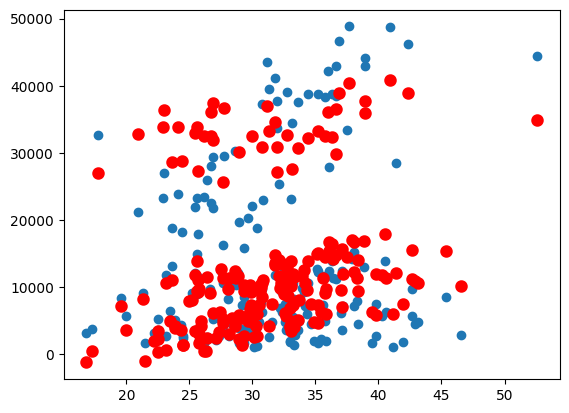

In [ ]:
from sklearn.linear_model import LinearRegression

model = make_pipeline(preprocessor, LinearRegression())
model.fit(X_train, y_train)
score = model.score(X_test, y_test)

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions, squared=False)
print('Score :', score)
print('MSE :', mse)

plt.scatter(X_test.bmi, y_test)
plt.scatter(X_test.bmi, predictions , c='r', lw=3)